## Facial Emotion Recognition using Neural Network
### Functions that read data from CSV file into arrays

In [1]:
from keras.utils import to_categorical
import pandas as pd
import numpy as np
import random
import sys
import warnings 
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import brewer2mpl

#  Re-classifies a  picture with disgust label into angry label
def emotion_count(y_train, classes):
    emo_classcount = {}
    print ('Disgust classified as Angry')

    # Locate all values that are disgust (1) in the 'emotion' column, replace with anger (0)
    y_train.loc[y_train == 1] = 0

    # Remove disgust from classes list
    classes.remove('Disgust')

    # Mapping emotion labels to numerical value and  count each emotion class
    for new_num, _class in enumerate(classes):
        y_train.loc[(y_train == emotion[_class])] = new_num
        class_count = sum(y_train == (new_num))
        emo_classcount[_class] = (new_num, class_count)
    return y_train.values, emo_classcount

# The function load provided CSV dataset and further reshape, rescale the data for feeding
def load_data(usage='Training',classes=['Angry','Happy'], filepath='fer2013.csv'):

     # Read CSV 
    df = pd.read_csv(filepath)
    df = df[df.Usage == usage]


    frames = []
    classes.append('Disgust')

    # Create a dataframe for each class (emotion) and append it to frames
    for _class in classes:
        class_df = df[df['emotion'] == emotion[_class]]
        frames.append(class_df)

    # Concatenate all the dataframes in the list frames to one dataframe "data"
    data = pd.concat(frames, axis=0)
    rows = random.sample(list(data.index), int(len(data)))
    data = data.loc[rows]

    x = list(data["pixels"])
    X = []

    # Determine the pixels for each image
    for i in range(len(x)):
        each_pixel = [int(num) for num in x[i].split()]
        X.append(each_pixel)
    
     # Reshape into 48*48*1 and rescale
    X = np.array(X)
    X = X.reshape(X.shape[0], 48, 48,1)
    X = X.astype("float32")
    X /= 255
    
    # return image classification data 
    y_train, new_dict = emotion_count(data.emotion, classes)
    y_train = to_categorical(y_train)
    return X, y_train

In [2]:
# Label each emotion with a numerical index 
emotion = {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3,
           'Sad': 4, 'Surprise': 5, 'Neutral': 6}
emo     = ['Angry', 'Fear', 'Happy',
           'Sad', 'Surprise', 'Neutral']

# Unizip the data and set the correct file path 
import zipfile
with zipfile.ZipFile('fer2013.zip','r') as zip_ref:
    zip_ref.extractall()
file_path = 'fer2013.csv'

# Load three sets of data: train, test, validation (find X_train, y_train, X_val, y_val, X_test, y_test using load_data function)
X_test, y_test = load_data(classes=emo, usage='PrivateTest', filepath=file_path)
X_train, y_train = load_data(classes=emo, usage='Training', filepath=file_path)
X_val,y_val = load_data(classes=emo, usage='PublicTest', filepath=file_path)

Disgust classified as Angry
Disgust classified as Angry
Disgust classified as Angry


## Model Architecture and Training

In [3]:
# Final Model Architecture:
from keras import layers
from keras import models
from keras import optimizers

# Change the parameters to improve the accuracy (Batch_size, nb_epoch, activation= relu, sigmoid, tanh, layers)
modelN = models.Sequential()
modelN.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu',
                        input_shape=(48, 48, 1)))
modelN.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
modelN.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
modelN.add(layers.MaxPooling2D(pool_size=(2, 2)))

modelN.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
modelN.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
modelN.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
modelN.add(layers.MaxPooling2D(pool_size=(2, 2)))

modelN.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
modelN.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
modelN.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
modelN.add(layers.MaxPooling2D(pool_size=(2, 2)))

modelN.add(layers.Flatten())  # this converts our 3D feature maps to 1D feature vectors
modelN.add(layers.Dense(64, activation='relu'))
modelN.add(layers.Dense(64, activation='relu'))
modelN.add(layers.Dense(6, activation='softmax'))

modelN.summary()
# optimizer:
modelN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print ('Training....')


# fit
nb_epoch = 5
batch_size = 400

modelF = modelN.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size,
          validation_data=(X_val, y_val), shuffle=True, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 64)        36928     
                                                        

## Save model and plot accuracy

INFO:tensorflow:Assets written to: facial_expression_model/assets


INFO:tensorflow:Assets written to: facial_expression_model/assets


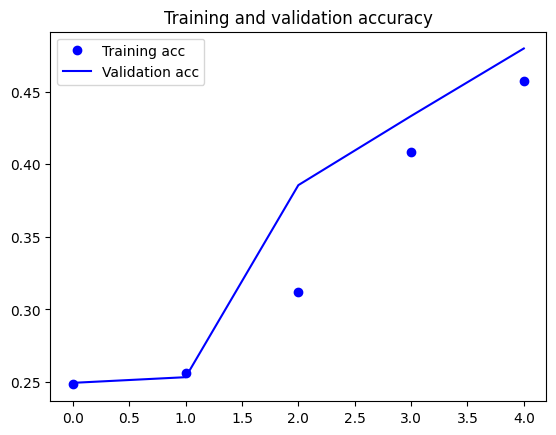

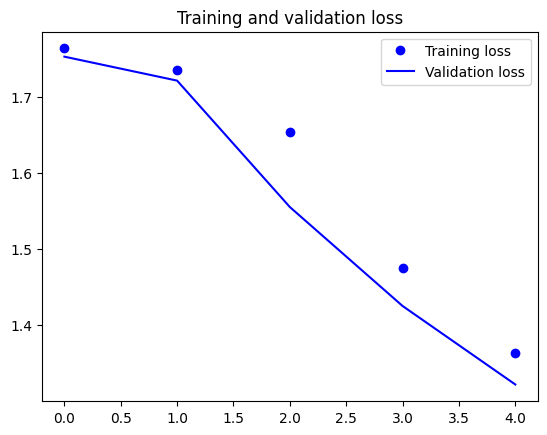

In [4]:
# Save model instance 
modelN.save('facial_expression_model')
modelN.save_weights('facial_expression_weights.h5')

# Get acuracy and loss 
acc = modelF.history['accuracy']
val_acc = modelF.history['val_accuracy']
loss = modelF.history['loss']
val_loss = modelF.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot the data 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Load private test set

In [5]:
# Store loaded data into numpy form for further processing
def save_data(X_test, y_test, fname=''):
    np.save( 'X_test' + fname, X_test)
    np.save( 'y_test' + fname, y_test)


save_data(X_test, y_test,"_privatetest6_100pct")
X_fname = 'X_test_privatetest6_100pct.npy'
y_fname = 'y_test_privatetest6_100pct.npy'

# Load images and labels in X and y variables
X = np.load(X_fname)
y = np.load(y_fname)

# Convert class probabilities to class indicies and print the count for each class 
print ('Private test set')
y_labels = [np.argmax(lst) for lst in y]
counts = np.bincount(y_labels)
labels = ['angry', 'fear', 'happy', 'sad', 'surprise', 'neutral']
print (labels)
print (counts)

Private test set
['angry', 'fear', 'happy', 'sad', 'surprise', 'neutral']
[546 528 879 594 416 626]


### Evaluate private test set

In [6]:
# Evaluate model on private test set
score = modelN.evaluate(X, y, verbose=0)
print ("model %s: %.2f%%" % (modelN.metrics_names[1], score[1]*100))

model accuracy: 46.70%


### Prediction on private test set

In [7]:
# Prediction and true labels
y_prob = modelN.predict(X, batch_size=32, verbose=0)

# Change the y_prob and y from binary arrays to integer and call them y_pred and y_true 
y_pred = np.argmax(y_prob, -1)
y_true = np.argmax(y, -1)

In [8]:
import matplotlib

# Plot the picture subjects
def plot_subjects(start, end, y_pred, y_true, title=False):

    # Set up plot
    fig = plt.figure(figsize=(12,12))

    # Index emotion labels 
    emotion = {0:'Angry', 1:'Fear', 2:'Happy', 3:'Sad', 4:'Surprise', 5:'Neutral'}

    # Add each image as a a subplot 
    for i in range(start, end+1):
        input_img = X[i:(i+1),:,:,:]
        ax = fig.add_subplot(6,6,i+1)
        ax.imshow(input_img[0,:,:,0], cmap=matplotlib.cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        if y_pred[i] != y_true[i]:
            plt.xlabel(emotion[y_true[i]], color='#53b3cb',fontsize=12)
        else:
            plt.xlabel(emotion[y_true[i]], fontsize=12)
        if title:
            plt.title(emotion[y_pred[i]], color='blue')
        plt.tight_layout()
    plt.show()

In [9]:
import brewer2mpl

#  Plot the probability in histogram for six labels 
def plot_probs(start,end, y_prob):
    
    # Set up plot 
    fig = plt.figure(figsize=(12,12))

    # Add each image to the histogram
    for i in range(start, end+1):
        input_img = X[i:(i+1),:,:,:]
        ax = fig.add_subplot(6,6,i+1)
        set3 = brewer2mpl.get_map('Set3', 'qualitative', 6).mpl_colors
        ax.bar(np.arange(0,6), y_prob[i], color=set3,alpha=0.5)
        ax.set_xticks(np.arange(0.5,6.5,1))
        labels = ['angry', 'fear', 'happy', 'sad', 'surprise','neutral']
        ax.set_xticklabels(labels, rotation=90, fontsize=10)
        ax.set_yticks(np.arange(0.0,1.1,0.5))
        plt.tight_layout()
    plt.show()

In [10]:
# Plot the probability together with its picture
def plot_subjects_with_probs(start, end, y_prob):
    iter = int((end - start)/6)
    for i in np.arange(0,iter):
        plot_subjects(i*6,(i+1)*6-1, y_pred, y_true, title=False)
        plot_probs(i*6,(i+1)*6-1, y_prob)

### Plot subjects and probability for n images usin functions above

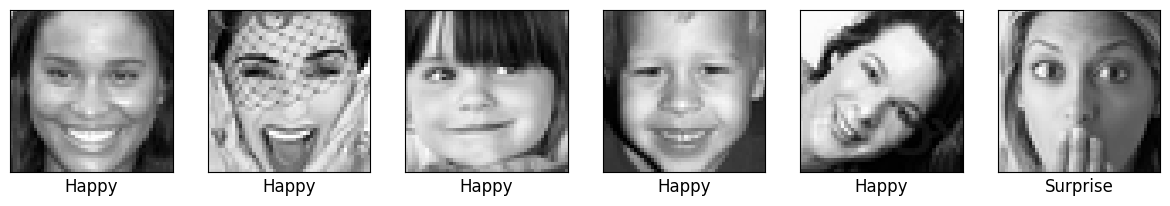

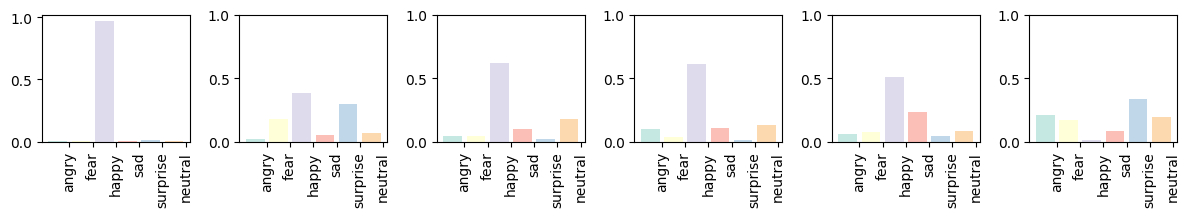

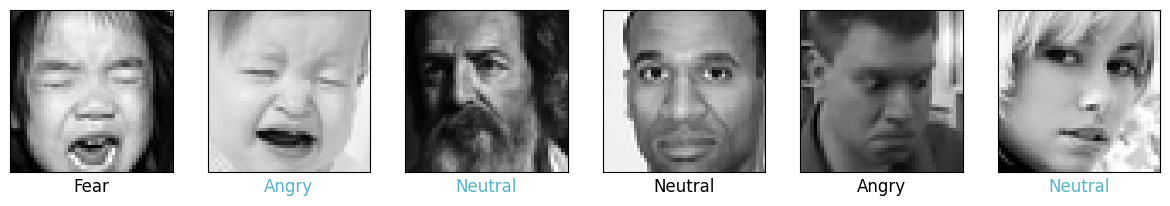

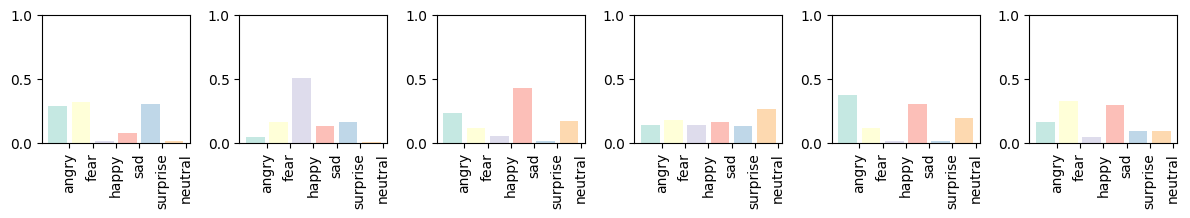

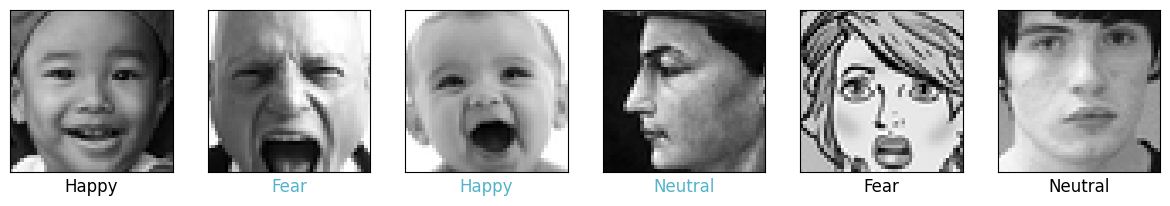

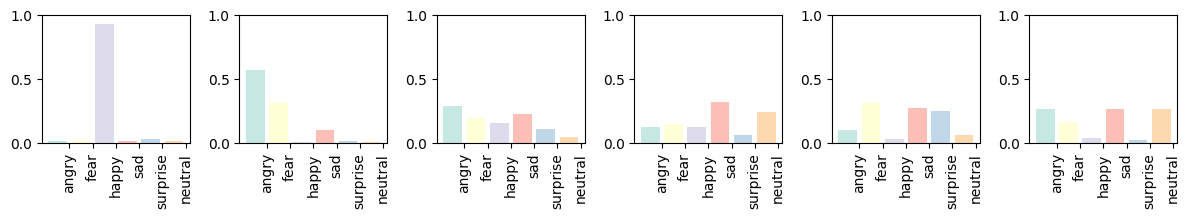

In [11]:
# plot subjects and probs for 20 images
plot_subjects_with_probs(0, 20, y_prob)

## Compare true and prediction results

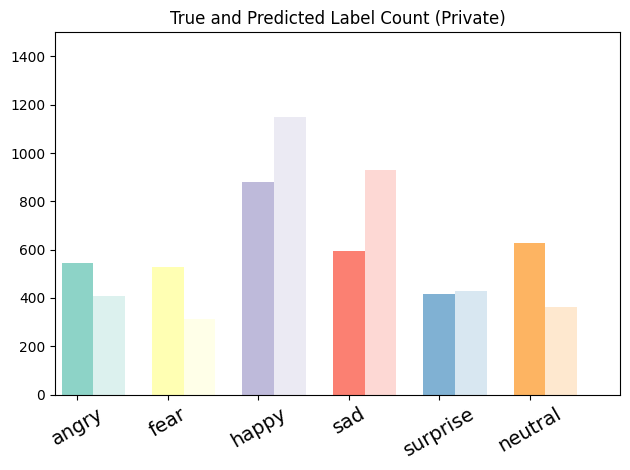

In [12]:
# Compare the number of true labels as well as prediction results
def plot_distribution2(y_true, y_pred):

    # Set up colours for the plot 
    colorset = brewer2mpl.get_map('Set3', 'qualitative', 6).mpl_colors

    # the x locations for the groups
    ind = np.arange(1.5,7,1)  

    # Set up plot 
    width = 0.35   
    fig, ax = plt.subplots()
    true = ax.bar(ind, np.bincount(y_true), width, color=colorset, alpha=1.0)
    pred = ax.bar(ind + width, np.bincount(y_pred), width, color=colorset, alpha=0.3)
    ax.set_xticks(np.arange(1.5,7,1))
    ax.set_xticklabels(labels, rotation=30, fontsize=14)
    ax.set_xlim([1.25, 7.5])
    ax.set_ylim([0, 1500])
    ax.set_title('True and Predicted Label Count (Private)')
    plt.tight_layout()
    plt.show()

plot_distribution2(y_true, y_pred)

### Plot confusion matrix

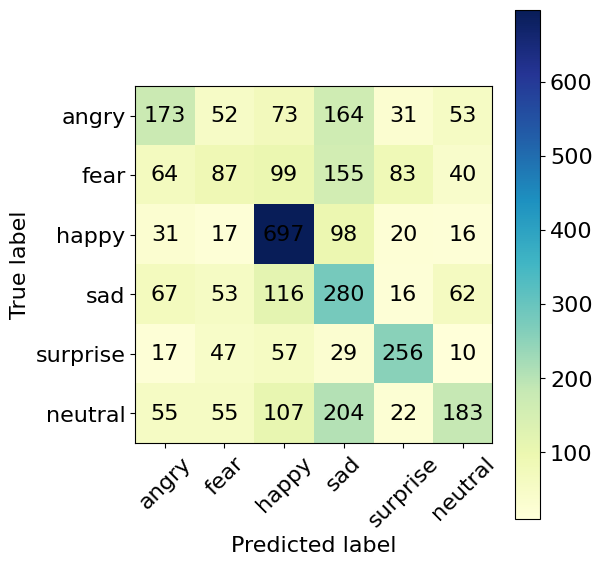

In [14]:
import matplotlib
from sklearn.metrics import confusion_matrix

# construct the confusion matrix 
def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.Blues):

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Set up plot 
    fig = plt.figure(figsize=(6,6))
    matplotlib.rcParams.update({'font.size': 16})
    ax  = fig.add_subplot(111)
    matrix = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    fig.colorbar(matrix) 

    # Add labels 
    for i in range(0,6):
        for j in range(0,6):  
            ax.text(j,i,cm[i,j],va='center', ha='center')
    ticks = np.arange(len(labels))
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.YlGnBu)
plt.show()

## Prediction on own data

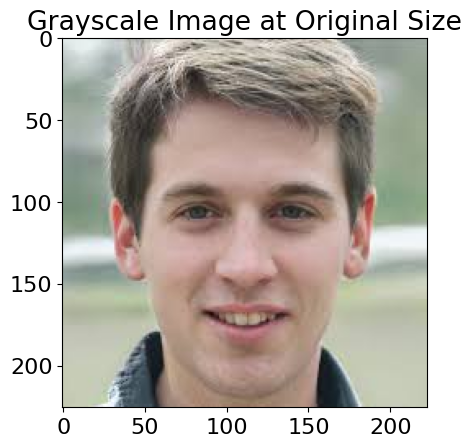

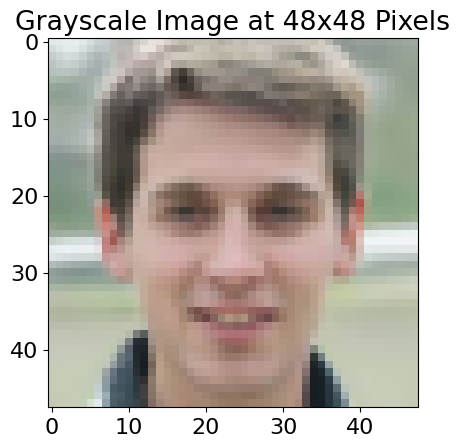

In [17]:
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in your image
input_img = mpimg.imread('sample.jpg')

# Plot original image 
plt.imshow(input_img, cmap='gray')
plt.title('Grayscale Image at Original Size')
plt.show()

# Resize the image 
resized_img = resize(input_img, (48, 48))

# Plot resized image
plt.imshow(resized_img, cmap='gray')
plt.title("Grayscale Image at 48x48 Pixels")
plt.show()

### Assign emotion label your image

In [18]:
# Give your image a label, set y_true
y_true = 2

### Process image for input to network¶

In [29]:
import numpy as np
import skimage

# Convert image to grayscale to convert to array 
grayscale_image = skimage.color.rgb2gray(resized_img)

# Convert image pixels to array 
img_array = np.array(grayscale_image)

# Convert image array shape and type 
img_array = img_array.reshape(1, 48, 48, 1)
img_array = img_array.astype("float32")
img_array /= 255

# Print array 
print(img_array)

[[[[0.00355077]
   [0.0035996 ]
   [0.00364179]
   ...
   [0.00250203]
   [0.00253623]
   [0.00256503]]

  [[0.00335708]
   [0.00350247]
   [0.00360656]
   ...
   [0.00243935]
   [0.00247587]
   [0.00250454]]

  [[0.00315117]
   [0.00326614]
   [0.00337659]
   ...
   [0.00241929]
   [0.00245628]
   [0.00247863]]

  ...

  [[0.00308638]
   [0.00310132]
   [0.00309666]
   ...
   [0.00309975]
   [0.0030939 ]
   [0.00307576]]

  [[0.0030689 ]
   [0.00307792]
   [0.00309612]
   ...
   [0.00310202]
   [0.00308286]
   [0.00306406]]

  [[0.0030569 ]
   [0.0030819 ]
   [0.00310377]
   ...
   [0.00309948]
   [0.00308802]
   [0.00307098]]]]


### Predict emotion of our image

In [26]:
# Predict probability of each emotion using model 
y_prob = modelN.predict(img_array, batch_size=1, verbose=0) # try using image from dataset, you will realize model is baised towards dataset
print(y_prob)

# Get the highest probabilities for each emotion
y_pred = [np.argmax(y_prob)]
print(y_pred)

[[0.16809848 0.09263694 0.13735549 0.39857087 0.01483563 0.18850257]]
[3]


In [30]:
import matplotlib

# Plot the picture subjects
def plot_subject(y_pred, y_true, img, title=False):

    # Set up plot 
    fig = plt.figure(figsize=(4,4))
    emotion = {0:'Angry', 1:'Fear', 2:'Happy', 3:'Sad', 4:'Surprise', 5:'Neutral'}

    # Add Image 
    plt.imshow(img, cmap=matplotlib.cm.gray)

    # Add axis
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))

    # Add label 
    if y_pred != y_true:
        plt.xlabel(emotion[y_true], color='#53b3cb',fontsize=12)
    else:
        plt.xlabel(emotion[y_true], fontsize=12)

    # Add title 
    if title:
        plt.title(emotion[y_pred], color='blue')
    
    # Show plot 
    plt.tight_layout()
    plt.show()


import brewer2mpl

# plot the probability in histogram for six labels
def plot_prob(y_prob):

    # Set up plot 
    fig = plt.figure(figsize=(4,4))

    # Set up plot colours 
    set3 = brewer2mpl.get_map('Set3', 'qualitative', 6).mpl_colors

    # Set up axis
    ax = plt.gca()
    ax.bar(np.arange(0,6), y_prob[0], color=set3,alpha=0.5)
    ax.set_xticks(np.arange(0.5,6.5,1))
    labels = ['angry', 'fear', 'happy', 'sad', 'surprise','neutral']
    ax.set_xticklabels(labels, rotation=90, fontsize=10)
    ax.set_yticks(np.arange(0.0,1.1,0.5))

    # Plot images 
    plt.tight_layout()
    plt.show()

# plot the probability together with its picture
def plot_subject_with_prob(img, y_prob, y_pred, y_true):
    plot_subject(y_pred, y_true, img, title=False)
    plot_prob(y_prob)

## Plot image and probabilities using above functions

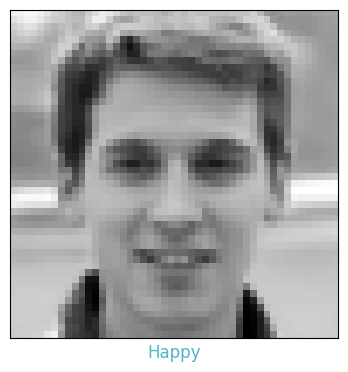

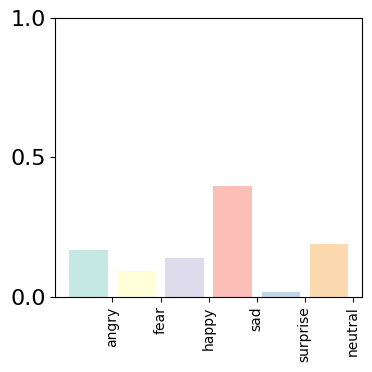

In [28]:
# Plot image and probabilities
plot_subject(y_pred, y_true, grayscale_image)
plot_prob(y_prob)